In [127]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from IPython import display
from torchvision.transforms import ToTensor, Normalize, Compose
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

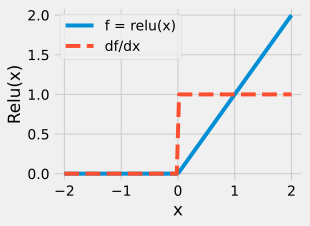

In [89]:
plt.figure(figsize=(4,3))
x = torch.linspace(-2.0, 2.0, 100, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();

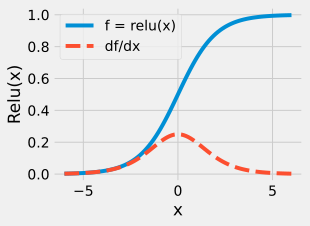

In [90]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();


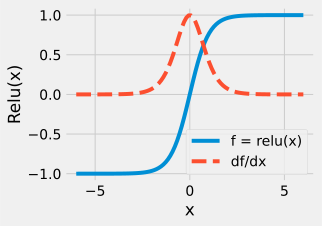

In [91]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.tanh(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();


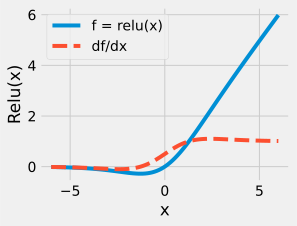

In [92]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.nn.functional.silu(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();

In [93]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Normalize((0.2860,), (0.3530,))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 1024, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 59, 10)

tensor(2.0227)
tensor(-0.0001)
tensor(0.9999)


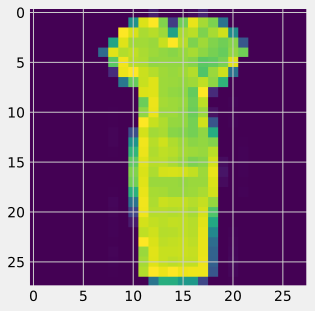

In [94]:
means = []
stds = []
for batch in data.train_dl:
    x, y = batch
    means.append(x.mean())
    stds.append(x.std())
    

img = x[0]

print (img.max())
plt.imshow(img.view(28,28));

print (sum(means)/len(means))
print (sum(stds)/len(means))


In [196]:
class Classifier(nn.Module):
    def __init__(self, in_features, out_features, num_hidden, lr=0.1):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(
            in_features, num_hidden)*(2.0/in_features)**0.5)
        self.b1 = nn.Parameter(torch.zeros(num_hidden)/in_features**0.5)

        self.W2 = nn.Parameter(torch.randn(
            num_hidden, num_hidden)*(2.0/num_hidden)**0.5)
        self.b2 = nn.Parameter(torch.zeros(num_hidden)/num_hidden**0.5)

        self.W3 = nn.Parameter(torch.randn(
            num_hidden, out_features)/num_hidden**0.5)
        self.b3 = nn.Parameter(torch.zeros(out_features)/num_hidden**0.5)

        self.lr = lr
        self.dropout = 0.5

        self.optimizer = self.configure_optimizer()

    def relu(self, x):
        a = torch.zeros_like(x)
        return torch.max(a, x)

    def training_step(self, x):
        x = x.view(-1, self.W1.shape[0])

        h1 = self.relu(x @ self.W1 + self.b1)
        h1 = self.dropout_layer(h1, self.dropout)

        h2 = self.relu(h1 @ self.W2 + self.b2)
        h2 = self.dropout_layer(h2, self.dropout)

        return h2 @ self.W3 + self.b3

    def validation_step(self, x):
        x = x.view(-1, self.W1.shape[0])
        h1 = self.relu(x @ self.W1 + self.b1)
        h2 = self.relu(h1 @ self.W2 + self.b2)
        return h2 @ self.W3 + self.b3

    def loss(self, x, y):
        return nn.functional.cross_entropy(x, y)

    def configure_optimizer(self):
        optimizer = torch.optim.SGD(self.parameters(), self.lr)
        return optimizer

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def dropout_layer(self, x, dropout):
        assert 0 <= dropout <= 1
        if dropout == 1.0:
            return torch.zeros_like(x)
        mask = (torch.rand(x.shape) > dropout).float()
        return mask * x / (1.0 - dropout)


In [197]:
model = Classifier(784, 10, 256, lr = 0.1)

In [198]:


class Trainer:
    def __init__(self, max_epochs, smooth=5):
        self.max_epochs = max_epochs
        self.smooth = smooth
        self.fig = None
        self.out_strings = ''

    def fit(self, model, train_data, val_data):
        epochs = []
        train_losses = []
        val_losses = []
        accuracies = []
        logits_std = []
        for epoch in range(1, self.max_epochs+1):
            for batch in train_data:

                # Minibatch
                x, y = batch

                # Forward
                logits = model.training_step(x)

                # loss
                train_loss = model.loss(logits, y)

                # Backward and update
                model.optimizer.zero_grad(set_to_none=True)
                train_loss.backward()
                model.optimizer.step()

            # Validation Loss
            with torch.no_grad():
                for batch in data.val_dl:
                    x, y = batch
                    logits = model.validation_step(x)
                    val_loss = model.loss(logits, y)
                    accuracy = model.accuracy(logits, y)
                    break

            epochs.append(epoch)
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(accuracy.item())
            logits_std.append(logits.std().item())
            #print (logits_std[-1])

            if epoch % self.smooth == 0:
                self.print_epoch(epochs, train_losses, val_losses, accuracies)
                self.plot(epochs, train_losses, val_losses, accuracies, logits.view(-1).detach())

    def print_epoch(self, epochs, train_losses, val_losses, accuracies):
        # Training losses

        out_string = f'Epoch {epochs[-1]:>4d}/{self.max_epochs:>4d}:  '
        out_string += f'training loss = {train_losses[-1]:6.3f},  '
        out_string += f'validation loss = {val_losses[-1]:6.3f},  '
        out_string += f'accuracy = {accuracies[-1]:6.3f}'
        out_string += '\n'
        self.out_strings += out_string
        print(self.out_strings)

    def plot(self, epochs, train_losses, val_losses, accuracies, logits):
        
        if self.fig is None:
            self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(10,3.75))
            self.init_logits = logits
            self.init_epoch = epochs[-1]

        # Smooth for plotting
        tl = torch.tensor(train_losses).view(-1, self.smooth).mean(axis=1)
        vl = torch.tensor(val_losses).view(-1, self.smooth).mean(axis=1)
        ac = torch.tensor(accuracies).view(-1, self.smooth).mean(axis=1)
        ep = torch.tensor(epochs).float().view(-1, self.smooth).mean(axis=1)

        # Make plots
        self.ax1.cla()
        self.ax1.plot(epochs, train_losses, 'C0', alpha=0.15)
        self.ax1.plot(epochs, val_losses, 'C1', alpha=0.15)
        self.ax1.plot(epochs, accuracies, 'C2', alpha=0.15)

        self.ax1.plot(ep, tl, 'C0', label='Train loss')
        self.ax1.plot(ep, vl, 'C1--', label='Val loss')
        self.ax1.plot(ep, ac, 'C2:', label='Accuracy')

        # Label Plots
        self.ax1.set_xlabel('Epochs')
        self.ax1.legend()

        self.ax2.cla()
        self.ax2.hist(self.init_logits,50,density=True,label=f'Epoch {self.init_epoch}',histtype='step',linewidth=5)
        self.ax2.hist(logits,50,density=True,label=f'Epoch {epochs[-1]}',histtype='step',linewidth=3)        
        self.ax2.set_xlabel('Logits')
        self.ax2.legend()

        if epochs[-1] < self.max_epochs:
            display.display(self.fig)
            display.clear_output(wait=True)
        else:
            display.display(self.fig)
            display.clear_output(wait=True)
            # Reprint out_strings since it was killed by clear outputs
            print(self.out_strings)


Epoch    5/ 100:  training loss =   0.57,  validation loss =   0.45,  accuracy =   0.82
Epoch   10/ 100:  training loss =   0.52,  validation loss =   0.39,  accuracy =   0.87
Epoch   15/ 100:  training loss =   0.41,  validation loss =   0.43,  accuracy =   0.84
Epoch   20/ 100:  training loss =   0.40,  validation loss =   0.40,  accuracy =   0.85
Epoch   25/ 100:  training loss =   0.38,  validation loss =   0.35,  accuracy =   0.87
Epoch   30/ 100:  training loss =   0.41,  validation loss =   0.37,  accuracy =   0.87
Epoch   35/ 100:  training loss =   0.36,  validation loss =   0.34,  accuracy =   0.87
Epoch   40/ 100:  training loss =   0.34,  validation loss =   0.37,  accuracy =   0.86
Epoch   45/ 100:  training loss =   0.39,  validation loss =   0.36,  accuracy =   0.88
Epoch   50/ 100:  training loss =   0.41,  validation loss =   0.35,  accuracy =   0.88
Epoch   55/ 100:  training loss =   0.31,  validation loss =   0.34,  accuracy =   0.88
Epoch   60/ 100:  training loss 

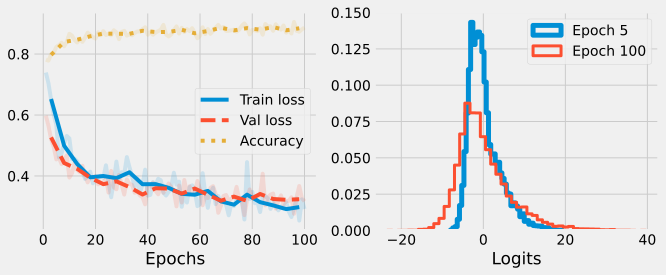

In [199]:
trainer = Trainer(max_epochs=100, smooth=5)
trainer.fit(model, data.train_dl, data.val_dl)

tensor(0.2863) tensor(0.3526)
tensor(1.)


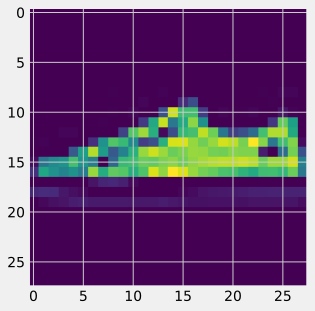

In [15]:
for batch in data.train_dl:
    x, y = batch
    print (x.mean(), x.std())
    break

img = x[0]

print (img.max())
plt.imshow(img.view(28,28));


In [214]:
# Lightning

# Define Model

torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 1024


class Classifier3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.Linear(784, 256), nn.ReLU(), nn.Dropout(0.5),
                                   nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.5),
                                   nn.Linear(256, 10))
        self.batch_size = 1024
        self.learning_rate = 0.3
        self.val_acc = torchmetrics.Accuracy(
            task='multiclass', num_classes=10)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log("train_loss", loss, prog_bar=False,
                 on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.val_acc(logits, y)

        # self.log('train_loss', loss)
        self.log("val_loss", loss, prog_bar=True,
                 on_step=False, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True,
                 on_step=False, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # x, y = batch
        x = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10)
        lr_scheduler = {"scheduler": scheduler,
                        "interval": "epoch", "monitor": "val_loss"}
        return [optimizer], [lr_scheduler]


model = Classifier3()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_3b2cf039-d5b5-4f4f-85fa-90f3cf9b66d0.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_3b2cf039-d5b5-4f4f-85fa-90f3cf9b66d0.ckpt


0.3311311214825908


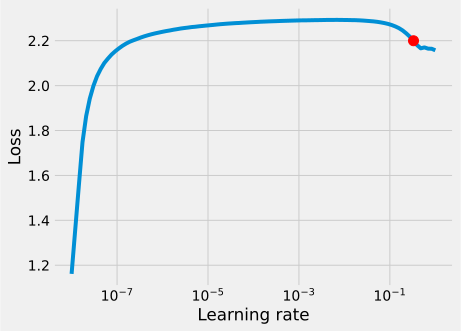

In [215]:
# run learning rate finder, results override hparams.learning_rate
trainer = pl.Trainer(auto_lr_find=True)

# call tune to find the lr
#lr_finder = trainer.tune(makemore, train_dataloaders=data)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=data.train_dl)

# Results can be found in
#print(lr_finder.results)
print (lr_finder.suggestion())

fig = lr_finder.plot(suggest=True)
fig.show()

In [216]:
mycallbacks = [TQDMProgressBar(refresh_rate=100),
               EarlyStopping(monitor="val_loss", mode="min", patience=20),
               LearningRateMonitor(logging_interval='epoch')]
trainer = pl.Trainer(max_epochs=150, accelerator="cpu", callbacks=mycallbacks)
trainer.fit(model=model, train_dataloaders=data.train_dl,
            val_dataloaders=data.val_dl)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | Sequential         | 269 K 
1 | val_acc | MulticlassAccuracy | 0     
-----------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.077     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [94]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [190]:
x = torch.randn((1000, 1000))*(2.0/1000)**0.5
y = torch.ones((1000,))

for i in range(100):
    y = nn.functional.relu(x @ y)
    x = torch.randn((1000, 1000))*(2.0/1000)**0.5

#print(x)
print (y.std())

tensor(0.8617)
